#Master equation model of the alanine octapeptide

First we import a number of libraries we will need as we run this example


In [36]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mastermsm.trajectory import traj
import mdtraj as md
from mastermsm.trajectory import traj_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [37]:
tr = traj.TimeSeries(top='data/ALA8_helix_amber03w_wat_min.gro',\
                     traj=['data/traj_whole_short.xtc'])

In [38]:
print tr.mdt

<mdtraj.Trajectory with 5001 frames, 89 atoms, 10 residues, and unitcells>


For example, we can access the $\phi$ and $\psi$ dihedrals for each of the aminoacids, which we will use in our discretization.

In [39]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

For each of the amino acids, we visualize the distribution of Ramachandran angles.

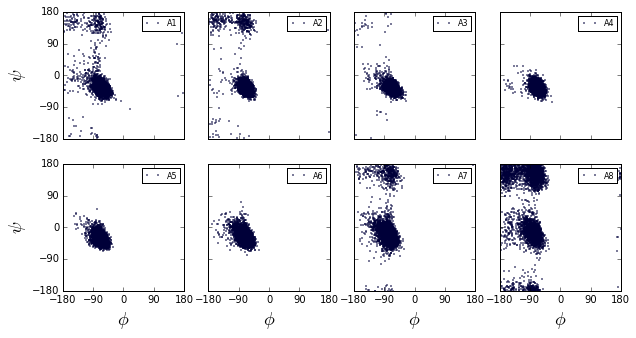

In [40]:
fig,ax = plt.subplots(2,4,figsize=(10,5), sharex=True, sharey=True)
k = 0
for i in range(2):
    for j in range(4):
        ax[i][j].plot(180./math.pi*phi[1][:,k],180./math.pi*psi[1][:,k],\
                      'o', markersize=1, label='A%g'%(k+1))
        ax[i][j].set_xlim(-180,180)
        ax[i][j].set_ylim(-180,180)
        ax[i][j].xaxis.set_ticks(range(-180,181,90))
        ax[i][j].yaxis.set_ticks(range(-180,181,90))
        ax[i][j].legend(fontsize=8)
        k +=1
ax[0][0].set_ylabel(r'$\psi$', fontsize=18)
ax[1][0].set_ylabel(r'$\psi$', fontsize=18)
for j in range(4):
    ax[1][j].set_xlabel(r'$\phi$', fontsize=18)

In [41]:
tr.discretize()

Now we check whether the discretization has captured the relevant dynamics at the single amino acid level. We look into residue 1 and residue 8, as examples.

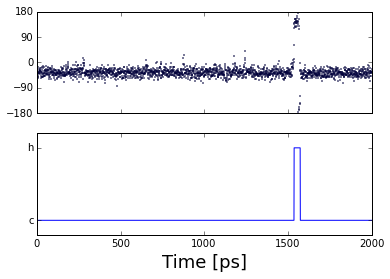

In [42]:
y = [0 if x[0] == 'A' else 1 for x in tr.distrajs]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1][:,0]*180/math.pi,'o', markersize=1)
ax2.plot(y)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=18)


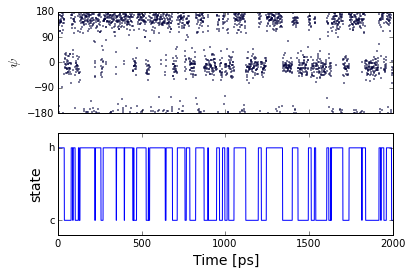

In [43]:
y = [0 if x[7] == 'A' else 1 for x in tr.distrajs]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1][:,7]*180/math.pi,'o', markersize=1)
ax2.plot(y)

ax1.set_ylabel(r'$\psi$', fontsize=14)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=14)
